In [7]:
import matplotlib
matplotlib.use('pgf')

%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pyov2sgd
import time
import pandas as pd

from IPython import display
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import roc_auc_score
from matplotlib.colors import LogNorm

from signal import signal, SIGPIPE, SIG_DFL
signal(SIGPIPE,SIG_DFL) 

/Users/Romain/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<Handlers.SIG_DFL: 0>

In [132]:
def generate_cov(p, t='white', **kwargs):
    if t is 'white':
        return kwargs['sigma'] * np.eye(p)
    elif t is 'toeplitz':
        return kwargs['sigma'] ** np.abs(np.arange(p).reshape(-1, 1) - 
                                         np.arange(p).reshape(1, -1))
    else:
        raise Exception('Unknown covariance structure.')
        
def simulate_serie(N, C_noise, W=None, ft='lin', **kwargs):
    p = C_noise.shape[0]
    if W is None:
        W = np.eye(p)
    serie = np.empty((N, p))
    
    serie[0, :] = np.random.multivariate_normal(np.zeros(p), C_noise)
    if ft is 'exp':
        nf = lambda x: np.exp(-kwargs['gamma1'] * x ** 2)
    elif ft is 'sin':
        nf = lambda x: np.sin(-kwargs['period'] * x)
    elif ft is 'lin':
        nf = lambda x: x
    elif ft is 'poly':
        nf = lambda x: x ** 3
    elif ft is 'tar':
        def f(x):
            x[np.abs(x) > 0.5] = x[np.abs(x) > 0.5] * 2.
            x[np.abs(x) > 1] = x[np.abs(x) > 1] / 1.5
            x[np.abs(x) > 1.5] = x[np.abs(x) > 1.5] / 2.
            return x
        nf = lambda x: f(x)
    elif ft is 'rff':
        phi = RBFSampler(n_components=1000, gamma=kwargs['gamma2'])
        theta = np.random.randn(1000, 1)
        nf = lambda x: np.dot(np.vstack((phi.fit_transform(x[i].reshape(1, -1)) 
                                         for i in range(p))), theta).ravel()
    else:
        raise Exception('Unknown non linearity function.')
    
    phi = RBFSampler(n_components=1000, gamma=kwargs['gamma2'])
    theta = np.random.randn(1000, p)
    for i in range(1, N):
        serie[i, :] = np.dot(W.T, nf(serie[i - 1, :])) + \
            np.random.multivariate_normal(np.zeros(p), C_noise)

    return serie +  0 * np.dot(phi.fit_transform(
            np.linspace(-1, 1, 1000).reshape(-1, 1)), theta)
        
    

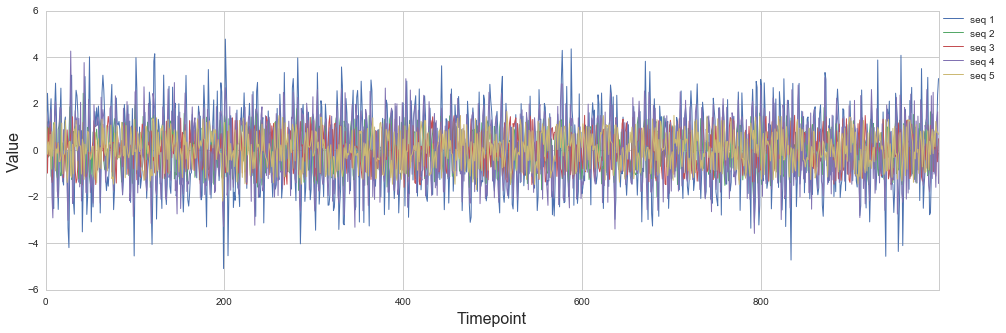

In [133]:
np.random.seed(0)
p = 5
n_interactions = 10

C_noise = generate_cov(p, 'white', sigma=.5)
W = .0 * np.eye(p)
N = 1000
for i in range(n_interactions):
    i1 = 0
    i2 = 0
    while i1 == i2:
        i1 = np.random.randint(p)
        i2 = np.random.randint(p)
    W[i1, i2] = np.random.normal(0, 10 * 1e-1)

serie = simulate_serie(N, C_noise, W=W, ft='tar', gamma1=10., 
                       gamma2=20., period=1.)
pserie = pd.Series(serie.ravel(), 
                   index=pd.MultiIndex.from_product([np.arange(N), 
                                                     np.arange(1, p + 1)], 
                                                    names=['timepoint', 
                                                           'serie']))

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1., rc={"lines.linewidth": 1.})
for i in range(1, p + 1):
    pserie[:, i].plot(figsize=(16, 5), alpha=1., 
                      label='seq ' + str(i), legend=True)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.)
plt.ylabel('Value', fontsize=16)
plt.xlabel('Timepoint', fontsize=16)
plt.savefig('serie_lin_white.pgf')
plt.show()

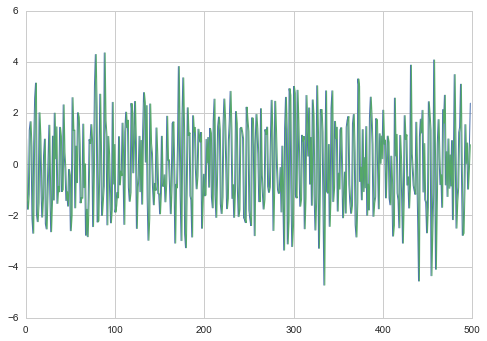

train: 0.418339~0.003609 in 0.001774s
test: 2.435644~1.458592 in 0.001774s


In [134]:
import statsmodels.tsa.api as tsa
import statsmodels.api as sm

Nw = N // 2
err = np.empty(len(range(Nw, N)))
err_t = np.empty(len(range(Nw, N)))
for (idx, i) in enumerate(range(Nw, N)):
    start = time.time()
    model = tsa.VAR(serie[i - Nw:i, :])
    results = model.fit(1, trend='c')
    stop = time.time()
    pred = serie[i - 1,:i :]

    err[idx] = np.mean((serie[i, :] - pred) ** 2)
    err_t[idx] = np.mean((serie[i - Nw + 1:i, :] - 
                          results.fittedvalues[0:Nw - 1, :]) ** 2)
    
display.clear_output(wait=True)
display.display(plt.gcf())
plt.cla()
plt.plot(serie[i - Nw + 1:i, 0])
plt.plot(serie[i - Nw:i - 1, 0])
    
display.clear_output(wait=True)
display.display(plt.gcf())
plt.close()

print('train: %f~%f in %fs' % (np.mean(err_t), np.std(err_t), stop - start))
print('test: %f~%f in %fs' % (np.mean(err), np.std(err), stop - start))

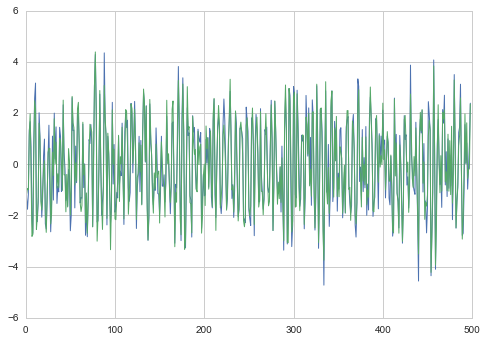

train: 0.418339~0.003609 in 0.001749s
test: 0.422403~0.237813 in 0.001749s


In [135]:
import statsmodels.tsa.api as tsa
import statsmodels.api as sm

Nw = N // 2
err = np.empty(len(range(Nw, N)))
err_t = np.empty(len(range(Nw, N)))
for (idx, i) in enumerate(range(Nw, N)):
    start = time.time()
    model = tsa.VAR(serie[i - Nw:i, :])
    results = model.fit(1, trend='c')
    stop = time.time()
    pred = results.forecast(serie[i - 1:i, :], 1)

    err[idx] = np.mean((serie[i, :] - pred) ** 2)
    err_t[idx] = np.mean((serie[i - Nw + 1:i, :] - 
                          results.fittedvalues[0:Nw - 1, :]) ** 2)
    
display.clear_output(wait=True)
display.display(plt.gcf())
plt.cla()
plt.plot(serie[i - Nw + 1:i, 0])
plt.plot(results.fittedvalues[0:Nw - 1, 0])
    
display.clear_output(wait=True)
display.display(plt.gcf())
plt.close()

print('train: %f~%f in %fs' % (np.mean(err_t), np.std(err_t), stop - start))
print('test: %f~%f in %fs' % (np.mean(err), np.std(err), stop - start))

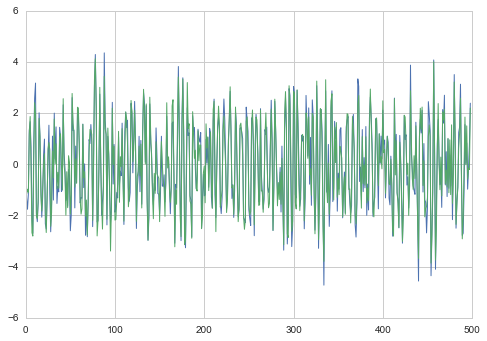

train: 0.383557~0.003692 in 0.155122s
test: 0.452650~0.261143 in 0.155122s


In [145]:
eta0 = 1.
lbda = 0.000001
nu = 0.
block = 25
cond = 1e-10
cap = -1
T = 10
L = pyov2sgd.RidgeLoss()
B = pyov2sgd.DecomposableGaussian(np.eye(p), 10)
# B = pyov2sgd.DecomposableSkewedChi2(np.eye(p), 20)
C = pyov2sgd.InverseScaling(eta0, 0, 0)

Nw = N // 2
err = np.empty(len(range(Nw, N)))
err_t = np.empty(len(range(Nw, N)))
for (idx, i) in enumerate(range(Nw, N)):
    X = serie[i - Nw    :i - 1, :].copy()
    y = serie[i - Nw + 1:i    , :].copy()
    batch = X.shape[0]

    estimator = pyov2sgd.DSOVK(L, B, C, p, lbda, nu, T, 
                               batch, block, cap, cond)
    start = time.time()
    estimator.fit_dense(X, y)
    stop = time.time()
    pred = estimator.predict_dense(serie[i - 1:i, :])
    err[idx] = np.mean((serie[i, :] - pred) ** 2)
    err_t[idx] = np.mean((serie[i - Nw + 1:i, :] - 
                          estimator.predict_dense(serie[i - Nw:i - 1, :])) ** 2)
    
display.clear_output(wait=True)
display.display(plt.gcf())
plt.cla()
plt.plot(serie[i - Nw + 1:i, 0])
plt.plot(estimator.predict_dense(serie[i - Nw:i - 1, :])[:, 0])

display.clear_output(wait=True)
display.display(plt.gcf())
plt.close()
    
print('train: %f~%f in %fs' % (np.mean(err_t), np.std(err_t), stop - start))
print('test: %f~%f in %fs' % (np.mean(err), np.std(err), stop - start))

In [64]:
import operalib as ovk

Nw = N // 2
err = np.empty(len(range(Nw, N)))
err_t = np.empty(len(range(Nw, N)))
for (idx, i) in enumerate(range(Nw, N)):
    X = serie[i - Nw    :i - 1, :].copy()
    y = serie[i - Nw + 1:i    , :].copy()
    batch = X.shape[0]

    estimator = ovk.Ridge('DGauss', lbda=0.000001, 
                          gamma=(1 / (2 * 2 ** 2)), A=np.eye(p))
    start = time.time()
    estimator.fit(X, y)
    stop = time.time()
    pred = estimator.predict(serie[i - 1:i, :])
    err[idx] = np.mean((serie[i, :] - pred) ** 2)
    err_t[idx] = np.mean((serie[i - Nw + 1:i, :] - 
                          estimator.predict(serie[i - Nw:i - 1, :])) ** 2)
    
display.clear_output(wait=True)
display.display(plt.gcf())
plt.cla()
plt.plot(serie[i - Nw + 1:i, 0])
plt.plot(estimator.predict(serie[i - Nw:i - 1, :])[:, 0])

display.clear_output(wait=True)
display.display(plt.gcf())
plt.close()
    
print('train: %f~%f in %fs' % (np.mean(err_t), np.std(err_t), stop - start))
print('test: %f~%f in %fs' % (np.mean(err), np.std(err), stop - start))

KeyboardInterrupt: 

In [194]:
1 / (2 * 15 ** 2)

0.0022222222222222222

In [18]:
W

array([[ 0.        , -0.03589956, -0.01234631,  0.        ,  0.        ],
       [ 0.11253141,  0.        ,  0.        ,  0.22408932,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.0291394 ],
       [ 0.14186671,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.0978738 ,  0.        , -0.01330903,  0.04283734,  0.        ]])